In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, LSTM, MaxPooling2D, Reshape
from tensorflow.keras import backend as K
import tensorflow as tf

/home/sergeyk/.local/share/virtualenvs/fsdl-text-recognizer-6Tfq_pVK/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
DATA_DIRNAME = Path('/home/sergeyk/work/iamdb')

crop_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped').glob('*.jpg')))
gt_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped-gt').glob('*.png')))

print(len(crop_filenames))

BATCH_SIZE = 64
NUM_BATCHES = 100

NUM_LABELS = 3

X = []
Y = []
for ind in range(min(len(crop_filenames), BATCH_SIZE * NUM_BATCHES)):
    name = crop_filenames[ind].stem
    image = cv2.imread(str(crop_filenames[ind]), cv2.IMREAD_GRAYSCALE)
    
    gt_filename = DATA_DIRNAME / 'forms-cropped-gt' / f'{name}.png'
    gt_image = cv2.imread(str(gt_filename), cv2.IMREAD_GRAYSCALE)
    
    for value in np.unique(gt_image):
        gt_image[gt_image == (value + 1)] = value % 2 + 1
#         gt_image[gt_image == (value + 1)] = 1
    X.append(image / 255)
    Y.append(to_categorical(gt_image.flatten(), NUM_LABELS))
    
X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.uint8)
print(X.shape, X.dtype, Y.shape, Y.dtype)

1315
(1315, 392, 310) float32 (1315, 121520, 3) uint8


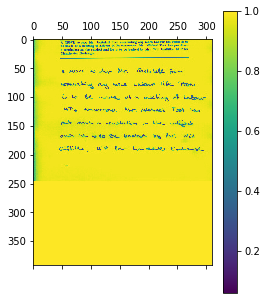

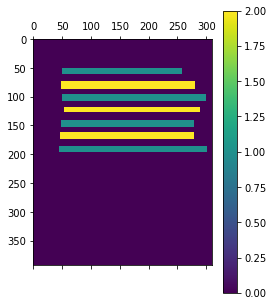

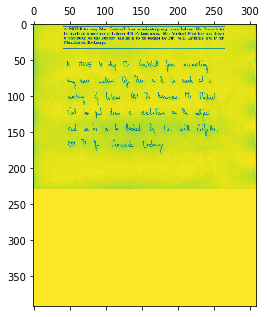

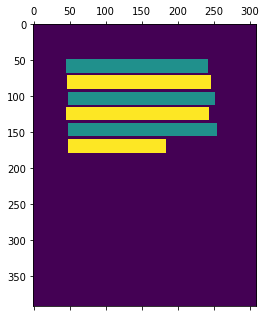

In [3]:
MAX_HEIGHT, MAX_WIDTH = X[0].shape

plt.matshow(X[0])
plt.colorbar()

plt.matshow(Y[0].reshape((MAX_HEIGHT, MAX_WIDTH, NUM_LABELS)).argmax(axis=-1))
plt.colorbar()

plt.matshow(X[1])

plt.matshow(Y[1].reshape((MAX_HEIGHT, MAX_WIDTH, NUM_LABELS)).argmax(axis=-1))

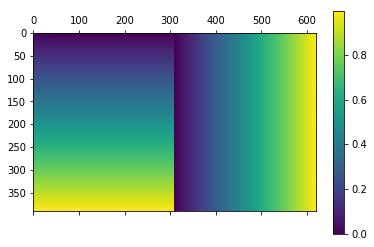

In [4]:
height_map = np.ones((MAX_HEIGHT, MAX_WIDTH))
height = np.arange(MAX_HEIGHT) / MAX_HEIGHT
height_map = height_map * np.expand_dims(height, 1)

width_map = np.ones((MAX_HEIGHT, MAX_WIDTH))
width = np.arange(MAX_WIDTH) / MAX_WIDTH
width_map = width_map * np.expand_dims(width, 0)

plt.matshow(np.hstack([height_map, width_map]))
plt.colorbar()

height_map = height_map.reshape((1, MAX_HEIGHT, MAX_WIDTH, 1))
width_map = width_map.reshape((1, MAX_HEIGHT, MAX_WIDTH, 1))

In [ ]:
KERNEL_SIZE = 5
DILATION_RATE = 3

height_map = K.variable(height_map)
width_map = K.variable(width_map)

input_image = Input((MAX_HEIGHT, MAX_WIDTH))
input_image_augmented = Lambda(
    lambda x: K.concatenate([
        K.expand_dims(x, -1),
        tf.tile(width_map, (K.shape(x)[0], 1, 1, 1)),
        tf.tile(height_map, (K.shape(x)[0], 1, 1, 1))
    ], axis=-1)
)(input_image)

def prediction_block(image, prediction=None, final_activation='relu'):
    if prediction is not None:
        image = Concatenate()([image, prediction])
    conv1 = Conv2D(64, kernel_size=KERNEL_SIZE, dilation_rate=DILATION_RATE, use_bias=True, padding='same')(image)
    bn1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(bn1)

    conv2 = Conv2D(32, kernel_size=KERNEL_SIZE, dilation_rate=DILATION_RATE, use_bias=True, padding='same', activation='relu')(conv1)
    bn2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(bn2)
    
#     conv12 = Add()([conv1, conv2])
    
    conv3 = Conv2D(NUM_LABELS, kernel_size=KERNEL_SIZE, dilation_rate=DILATION_RATE, padding='same', activation=final_activation)(conv2)
    # Useful calculator: https://fomoro.com/projects/project/receptive-field-calculator
    return conv3

prediction = prediction_block(input_image_augmented)
prediction = prediction_block(input_image_augmented, prediction)
prediction = prediction_block(input_image_augmented, prediction)
prediction = prediction_block(input_image_augmented, prediction, 'softmax')

output = Reshape((MAX_HEIGHT * MAX_WIDTH, NUM_LABELS))(prediction)
model = Model(inputs=input_image, outputs=output)
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3)
]
history = model.fit(x=X, y=Y, epochs=32, batch_size=8, validation_split=0.2, callbacks=callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 392, 310)     0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 392, 310, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 392, 310, 64) 4864        lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 392, 310, 64) 256         conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation

In [6]:
model.evaluate(X, Y, batch_size=8)

1315/1315 [==============================] - 20s 15ms/step


[0.5503354381699073, 0.8219897404369746]

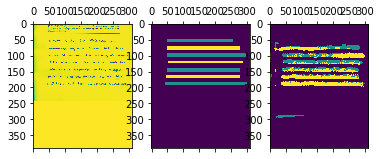

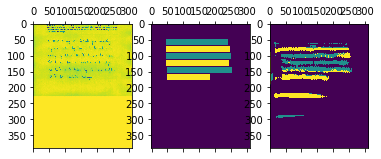

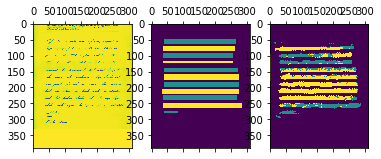

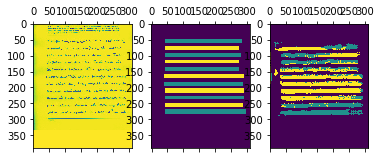

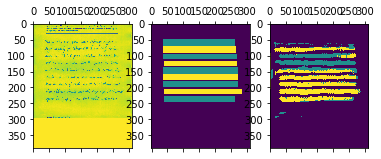

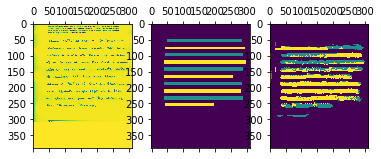

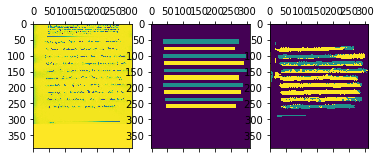

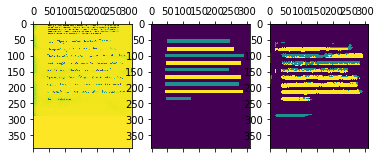

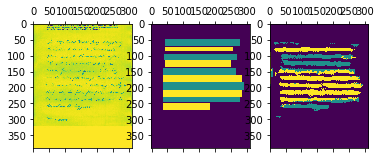

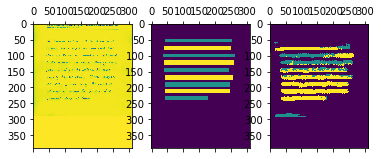

In [8]:
preds = model.predict(X)
def plot_gt_and_pred(ind, preds=preds):
    sample_input = np.expand_dims(X[ind], 0)
    gt = Y[ind].reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    pred = preds[ind].reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1.matshow(X[ind].squeeze())
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt)
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred)

for ind in range(10):
    plot_gt_and_pred(ind)